In [228]:
import sys
sys.path.append('C:/Anaconda3/Lib/site-packages')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

import traceback
%load_ext snakeviz
from tqdm import tqdm_notebook, tqdm

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


## European Football Kaggle Database
Author: Alex Galea
- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Player's statistics sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches
---
I would like to develop an algorithm for identifying "good bets" where the better is likely to beat the odds. This is a supervised learning problem where the target is probably a binary classification (win/loss or over/under).

The idea here is not to try and predict the winner, but instead guess probabilities and identify situations where you can "beat the odds". For example: for a given team and season, compute the probabilities of winning the bet for each game and compare to the odds. Then look at the cases where there is the largest difference between predicted probabilites and odds.

In [2]:
conn = sqlite3.connect('EA_ML_database.sqlite')
c = conn.cursor()

In [3]:
def reset_conn(conn, c):
    conn.close()
    conn = sqlite3.connect('EA_ML_database.sqlite')
    c = conn.cursor()
    return conn, c

#### Team, country, league dictionaries

In [4]:
# Team id
c.execute('PRAGMA TABLE_INFO(Team)')
c.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'team_api_id', 'INTEGER', 0, None, 0),
 (2, 'team_long_name', 'TEXT', 0, None, 0),
 (3, 'team_short_name', 'TEXT', 0, None, 0)]

In [5]:
id_team_long, id_team_short = {}, {}
row_id = 0
c.execute('SELECT MAX(id) FROM Team')
max_id = c.fetchall()[0][0]
while True:
    try:
        c.execute('SELECT team_api_id, team_long_name, team_short_name FROM Team WHERE id="{}"'.\
                  format(row_id))
        query = c.fetchall()[0]
        id_team_long[query[0]] = query[1]
        id_team_short[query[0]] = query[2]
    except:
        pass
    if row_id == max_id:
        print('Final row reached (number {0:s})'.format(str(row_id)))
        break
    row_id += 1

Final row reached (number 51538)


In [6]:
for i in list(id_team_long.keys())[:10]:
    print(id_team_long[i], id_team_short[i])
print('...')

Fortuna Duesseldorf FDU
FC Zuerich ZUR
Leicester LEI
Montpellier MON
KV Mechelen MEC
Aston Villa AVL
Troyes TRO
Ajax AJA
Wolfsburg WOL
FC Cologne FCK
...


In [7]:
# Country id
ids = [i[0] for i in c.execute('SELECT id FROM Country').fetchall()]
names = [i[0] for i in c.execute('SELECT name FROM Country').fetchall()]
id_country = {i: n for i, n in zip(ids, names)}
id_country

{1: 'Belgium',
 1729: 'England',
 4735: 'France',
 7775: 'Germany',
 10223: 'Italy',
 13240: 'Netherlands',
 15688: 'Poland',
 17608: 'Portugal',
 19660: 'Scotland',
 21484: 'Spain',
 24524: 'Switzerland'}

In [8]:
# League id
ids = [i[0] for i in c.execute('SELECT id FROM League').fetchall()]
names = [i[0] for i in c.execute('SELECT name FROM League').fetchall()]
id_league = {i: n for i, n in zip(ids, names)}
id_league

{1: 'Belgium Jupiler League',
 1729: 'England Premier League',
 4735: 'France Ligue 1',
 7775: 'Germany 1. Bundesliga',
 10223: 'Italy Serie A',
 13240: 'Netherlands Eredivisie',
 15688: 'Poland Ekstraklasa',
 17608: 'Portugal Liga ZON Sagres',
 19660: 'Scotland Premier League',
 21484: 'Spain LIGA BBVA',
 24524: 'Switzerland Super League'}

#### Useful features?
This may involve a lot of data collection on my part.
- teams
    - include ELO score (points at that given time in the season) as a fraction (i.e. home_ELO_score/away_ELO_score). when extracting will have to assign ELO score of 1 if 0 (at start of season) to aviod dividing by zero errors with ratio
    - home or away
    - goals on the year
- players
    - cumulative player stats (i.e. total career goals)
- meta
    - betting odds?? since I'm ultimately comparing to the betting odds, is it cheating if I also include the average betting odds across all companies as a feature?

*the Elo system is widely used by sharp bettors as a reliable tool in the search of value bets, i.e. bets with positive expected value, because it provides a solid statistical foundation for calculating the probabilities of the different outcomes with great accuracy.

___

Let's start with just the FIFA EA player data (which has time dependence!) and generate features for each game.

- use average value of all players on the team
    - break it down by position so that each has different weights?
- do something else for binary features

### Feature engineering: Combine EA Sports player data and add to Match table for each game

In [9]:
# c.execute('SELECT MAX(id) FROM Match')
# max_id = c.fetchall()[0][0]

# List of row ids for Match table
c.execute('SELECT id FROM Match')
Match_id = [f[0] for f in sorted(c.fetchall(), key=lambda x: x[0])]
print('Number of matches:', len(Match_id))

Number of matches: 24113


In [10]:
# Perentage of column that has an entry

def isMatchElement(column, row_id):
    c.execute('SELECT {0:s} FROM Match WHERE id="{1:d}"'.\
              format(column, row_id))
    query = c.fetchall()[0]
    if not query[0]:
        return False
    else:
        return True

def fullFrac(column, Match_id):
    column_isnul = [isMatchElement(column, row_id) for row_id in Match_id]
    return column, np.sum(column_isnul)/len(column_isnul)

full_frac = fullFrac('id', Match_id)
print(full_frac)

full_frac = fullFrac('goal', Match_id)
print(full_frac)

full_frac = fullFrac('home_player_1', Match_id)
print(full_frac)

('id', 1.0)
('goal', 0.0)
('home_player_1', 0.99485754572222451)


I find the goal column confusing as there are no entries. It seems also that about 5% of the games are missing player info as well.

What Y values are we dealing with and how can we determine forwards vs defense ..etc.

In [11]:
cols = ", ".join(["away_player_Y"+str(i) for i in range(1,12)])
c.execute('SELECT {0:s} FROM Match'.\
         format(cols))
aa = c.fetchall()

bb = np.array([a for row in aa for a in row])
from collections import Counter
Counter(bb)

Counter({1: 24113,
         3: 95306,
         5: 2892,
         6: 15787,
         7: 58435,
         8: 23311,
         9: 2738,
         10: 31029,
         11: 11632})

With motivation to keep the distribution as even as possible, we have:  
1 - goalie  
3 - defence  
5, 6, 7 - mid  
8, 9, 10, 11 - forward  

Will have to be careful with the incomplete ones. We'll treat Y=0 as None.

Here are some examples of incomplete entries:

In [12]:
c.execute('SELECT {0:s} FROM Match'.\
         format("id, "+", ".join(["away_player_Y"+str(i) for i in range(1,12)])))
aa = c.fetchall()

In [13]:
[row for row in aa if row[1]==0]

[]

In [14]:
print([row for row in aa if row[1]==None][:10])
print('...')

[]
...


What is the distribution of missing entries?

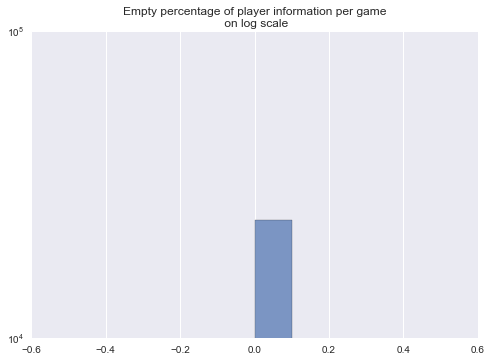

In [15]:
#%%snakeviz
empty_percentage = []
for row in aa:
    empty_percentage.append(np.sum([r==0 or r==None for r in row[1:]])/len(row[1:]))

fig, ax = plt.subplots()
ax.hist(empty_percentage, alpha=0.7)
ax.set_yscale('log')
ax.set_title('Empty percentage of player information per game\n on log scale')

Let's remove these completely empty rows from the database. Recall we have opened a copy of the original called `EA_ML_database.sqlite`

In [16]:
del_ids = [str(a[0]) for a in aa
           if False not in
           [i==None or i==0 for i in a[1:]]]
len(del_ids)

0

In [17]:
c.execute('DELETE FROM Match WHERE id IN ({})'.\
          format(', '.join(del_ids)))
conn.commit()

Below is a terribly ugly looking function that does the feature engineering. It's been coded to be pretty general but it's best to __keep things simple to start__. Here is a tentative plan:
1. Use average overall_rating for F, M, D, average stats for goalie
2. Use detailed stats for team (ignore positions), ignore goalie
3. Use detailed stats for team (ignore positions), include goalie details

In [18]:
EA_stats = {'player': ', '.join(['overall_rating']), #'attacking_work_rate', 'defensive_work_rate',
#                                   'crossing', 'finishing', 'heading_accuracy', 'short_passing',
#                                   'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
#                                   'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
#                                   'agility', 'reactions', 'balance', 'shot_power', 'jumping',
#                                   'stamina', 'strength', 'long_shots', 'interceptions',
#                                   'positioning', 'vision', 'penalties', 'marking',
#                                   'standing_tackle', 'sliding_tackle']),
            'goalie': ', '.join(['gk_diving', 'gk_handling', 'gk_kicking',
                                 'gk_positioning', 'gk_reflexes'])}


def getTeamScores(match_id, team, EA_stats,
                  printout=False,
                  group='forward_mid_defense_goalie'):
    ''' Return the cumulative average team scores for 
    a given EA Sports FIFA statistic. If particular EA
    stats are not in the database that stat is taken as
    the overall player rating. If any positional stat is
    unavailable (i.e. no goalie information) that stat is
    taken as the average of the others for that team.
    team : str
        'home' or 'away'
    EA_stat : dict
        Names of statistics to cumulate for goalie and players.
        e.g. {'player': 'overall_rating, heading_accuracy',
              'goalie': 'gk_diving, gk_handling'}
    printout : boolean
        Option to print out debug information,
        defaults to False.
    group : str
        How to group scores:
        'forward_mid_defense_goalie': output 4 values
        'all': output 1 value (currently not implemented)
    '''
    
    if team == 'home':
        player_cols = ', '.join(['home_player_'+str(i) for i in range(1,12)])
        player_Y_cols = np.array(['home_player_Y'+str(i) for i in range(1,12)])
    elif team == 'away':
        player_cols = ', '.join(['away_player_'+str(i) for i in range(1,12)])
        player_Y_cols = np.array(['away_player_Y'+str(i) for i in range(1,12)])
        
    # Get the player ids from the Match table
    c.execute('SELECT {0:s} FROM Match WHERE id={1:d}'.\
             format(player_cols, match_id))
    player_api_id = np.array(c.fetchall()[0])
    
    # Exit if all items in the list are null
    if False not in [p==0 or p==None for p in player_api_id]:
        raise LookupError('No player data found for Match table row_id={}'.\
                                   format(match_id))
        
    # Remove any empty player entries (if player_api_id == None or nan)
    empty_mask = player_api_id != np.array(None)
    player_api_id = player_api_id[empty_mask]
    player_Y_cols = ', '.join(player_Y_cols[empty_mask])
    
    # Get the player positions from the Match table
    # We only care about the Y position to designate
    # forwards, midfielders, defense, and goalie
    
    c.execute('SELECT {0:s} FROM Match WHERE id={1:d}'.\
             format(player_Y_cols, match_id))
    player_Y = c.fetchall()[0]
    
    def givePosition(Y):
        ''' Input the Y position of the player (as opposed
        to the lateral X position) and return the categorical
        position. '''
        if Y == 1:
            return 'G'
        elif Y == 3:
            return 'D'
        elif Y == 5 or Y == 6 or Y == 7:
            return 'M'
        elif Y == 8 or Y == 9 or Y == 10 or Y == 11:
            return 'F'
        else:
            sys.exit('Unknown value for Y: {}'.\
                    format(Y))
    player_pos = np.array([givePosition(Y) for Y in player_Y])
    
    # Get the match date
    
    def toDatetime(datetime):
        ''' Convert string date to datetime object. '''
        return dt.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

    c.execute('SELECT date FROM Match WHERE id={}'.\
             format(match_id))
    match_date = toDatetime(c.fetchall()[0][0])
    
    # Lookup the EA Sports stats for each player
    # The stats are time dependent so we have to
    # find the ones closest to the match date
    
    def getBestDate(player_id, match_date):
        ''' Find most suitable player stats to use based
        on date of match and return the corresponding row
        id from the Player_Stats table. ''' 
        c.execute('SELECT id FROM Player_Stats WHERE player_api_id={}'.\
                 format(player_id))
        ids = np.array([i[0] for i in c.fetchall()])
        c.execute('SELECT date_stat FROM Player_Stats WHERE player_api_id={}'.\
                 format(player_id))
        dates = [toDatetime(d[0]) for d in c.fetchall()]
        dates_delta = np.array([abs(d-match_date) for d in dates])
        return ids[dates_delta==dates_delta.min()][0]
    
    def fill_empty_stats(stats, stat_names):
        ''' Input the incomplete EA player stats and corresponing
        names, return the filled in stats list. Filling with
        overall_rating or averaging otherwise (i.e. for goalies
        where there is no overall_rating stat). '''
        if not np.sum([s==0 or s==None for s in stats]):
            return stats
        stats_dict = {sn: s for sn, s in zip(stat_names, stats)}
        try:
            fill = stats_dict['overall_rating']
        except:
            # Either a goalie or player with no overall rating
            # Filling with average of other stats
            fill = np.mean([s for s in stats if s!=0 and s!=None])
        filled_stats = []
        for s in stats:
            if s==None or s==0:
                filled_stats.append(fill)
            else:
                filled_stats.append(s)
        return filled_stats
    
    positions = ('G', 'D', 'M', 'F')
    average_stats = {}
    for position in positions:
        if printout: print(position)
        if position == 'G':
            stats = EA_stats['goalie']
        else:
            stats = EA_stats['player']
        position_ids = player_api_id[player_pos==position]
        average_stats[position] = np.zeros(len(stats.split(',')))
        for player_id in position_ids:
            if printout: print(player_id)
            best_date_id = getBestDate(player_id, match_date)
            c.execute('SELECT {0:s} FROM Player_Stats WHERE id={1:d}'.\
                     format(stats, best_date_id))
            query = np.array(c.fetchall()[0])
            query = fill_empty_stats(query, stats.split(', '))
            if printout: print(query)
            if sum([q==None or q==0 for q in query]):
                raise LookupError('Found null EA stats entry at stat_id={}'.\
                                  format(best_date_id))
#                 sys.exit('Found null EA stats entry at stat_id={}'.\
#                         format(best_date_id))
            average_stats[position] += query
            if printout: print('')
        average_stats[position] /= len(position_ids) # take average
            
    # Take average of goalie stats
    try:
        average_stats['G'] = np.array([average_stats['G'].mean()])
    except:
        # Missing info: (average_stats['G']) = 0
        pass
    
    # Insert missing stats
    insert_value = np.mean([v[0] for v in average_stats.values() if not np.isnan(v)])
    for k, v in average_stats.items():
        if np.isnan(v[0]):
            average_stats[k] = np.array([insert_value])
    
#     # Return a dictionary of numeric results as strings for storing in SQL table
#     return {key: ' '.join([str(v) for v in value]) for key, value in average_stats.items()}
#     ''' THE LINE ABOVE NEEDS A FIX - UNABLE TO ADD STRINGS LIKE THIS TO SQL TABLE '''        
    return average_stats

def print_exception(e, e_id):
    print('id=', e_id, str(e))
    with open('errors.out', 'a') as f:
        f.write('id={}, error={}'.format(e_id, e))
        f.write('\n')
    ex_type, ex, tb = sys.exc_info()
    traceback.print_tb(tb)

In [19]:
try:
    avg = getTeamScores(148, 'home', EA_stats, printout=True)
except LookupError as e:
    print('LookupError')
    print_exception(e, i)
except Exception as e:
    print_exception(e, i)
    
avg

G
D
39580
[74]

30692
[75]

37861
[67]

47411
[71]

M
119117
[64]

35412
[71]

39631
[76]

39591
[75]

F
25957
[71]

38369
[74]



{'D': array([ 71.75]),
 'F': array([ 72.5]),
 'G': array([ 71.91666667]),
 'M': array([ 71.5])}

In [20]:
# Add columns for the new features
old_cols = [n[1] for n in c.execute('PRAGMA TABLE_INFO(Match)').fetchall()]
new_cols = ['home_F_stats', 'home_M_stats', 'home_D_stats', 'home_G_stats',
            'away_F_stats', 'away_M_stats', 'away_D_stats', 'away_G_stats']
for n in new_cols:
    if n not in old_cols:
        c.execute('ALTER TABLE Match ADD COLUMN {} REAL'.\
                 format(n))
conn.commit()

In [21]:
c.execute('PRAGMA TABLE_INFO(Match)')
c.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'country_id', 'INTEGER', 0, None, 0),
 (2, 'league_id', 'INTEGER', 0, None, 0),
 (3, 'season', 'TEXT', 0, None, 0),
 (4, 'stage', 'INTEGER', 0, None, 0),
 (5, 'date', 'TEXT', 0, None, 0),
 (6, 'match_api_id', 'INTEGER', 0, None, 0),
 (7, 'home_team_api_id', 'INTEGER', 0, None, 0),
 (8, 'away_team_api_id', 'INTEGER', 0, None, 0),
 (9, 'home_team_goal', 'INTEGER', 0, None, 0),
 (10, 'away_team_goal', 'INTEGER', 0, None, 0),
 (11, 'home_player_X1', 'INTEGER', 0, None, 0),
 (12, 'home_player_X2', 'INTEGER', 0, None, 0),
 (13, 'home_player_X3', 'INTEGER', 0, None, 0),
 (14, 'home_player_X4', 'INTEGER', 0, None, 0),
 (15, 'home_player_X5', 'INTEGER', 0, None, 0),
 (16, 'home_player_X6', 'INTEGER', 0, None, 0),
 (17, 'home_player_X7', 'INTEGER', 0, None, 0),
 (18, 'home_player_X8', 'INTEGER', 0, None, 0),
 (19, 'home_player_X9', 'INTEGER', 0, None, 0),
 (20, 'home_player_X10', 'INTEGER', 0, None, 0),
 (21, 'home_player_X11', 'INTEGER', 0, None, 0),
 (22

In [22]:
# Get row ids for our Match table
all_ids = c.execute('SELECT id FROM Match').fetchall()
all_ids = [i[0] for i in sorted(all_ids)]

In [23]:
# Don't want to do this: will stick the value at the end
# of the table in a new row!!!
#
# c.execute('INSERT INTO Match (home_F_stats, away_F_stats)'+\
#           'VALUES (100, 50)')
#
# Proper way to update table info:
# c.execute('UPDATE Match SET home_F_stats={}, away_F_stats={} WHERE id={}'.\
#          format('100', '50', all_ids[0]))
#
# Test query for updates
# c.execute('SELECT * FROM Match WHERE id={}'.\
#          format(all_ids[0])).fetchall()

In [24]:
conn, c = reset_conn(conn, c)

In [25]:
# c.execute('SELECT * FROM Match WHERE id={}'.format(all_ids[-1])).fetchall()

In [26]:
%%snakeviz
# Get stats for each game and insert into
# Match table as TEXT (will have to decode later)
f = open('errors.out', 'w'); f.close() # Erase error file
for i in tqdm_notebook(all_ids):
    try:
        # Add home team features
        h_stats = getTeamScores(i, 'home', EA_stats, printout=False)
        c.execute('UPDATE Match SET '+\
                  'home_F_stats={}, home_M_stats={}, home_D_stats={}, home_G_stats={} '.\
                  format(h_stats['F'][0], h_stats['M'][0], h_stats['D'][0], h_stats['G'][0])+\
                  'WHERE id={}'.format(i))
        # Add away team features
        a_stats = getTeamScores(i, 'away', EA_stats, printout=False)
        c.execute('UPDATE Match SET '+\
                  'away_F_stats={}, away_M_stats={}, away_D_stats={}, away_G_stats={} '.\
                  format(a_stats['F'][0], a_stats['M'][0], a_stats['D'][0], a_stats['G'][0])+\
                  'WHERE id={}'.format(i))
    except LookupError as e:
        print('LookupError')
        print_exception(e, i)
    except Exception as e:
        print_exception(e, i)


 
*** Profile stats marshalled to file 'C:\\Users\\agale\\AppData\\Local\\Temp\\tmpqgpj24rb'. 


In [27]:
conn.commit()

#### Goodby SQL and hello Pandas

In [28]:
# Load the desired columns into a dataframe
features = ['home_F_stats', 'home_M_stats', 'home_D_stats', 'home_G_stats',
           'away_F_stats', 'away_M_stats', 'away_D_stats', 'away_G_stats']

df = pd.read_sql(sql='SELECT {} FROM Match'.\
                 format('id, country_id, league_id, season, stage, '+\
                        'date, home_team_api_id, away_team_api_id, '+\
                        'home_team_goal, away_team_goal, '+\
                        ', '.join(features)),
                 con=conn)

In [29]:
# Adding a game state column:
# a list of the form [H, D, A]
# state = [1, 0, 0], result = 1 => Home team win
# state = [0, 1, 0], result = 2 => Draw
# state = [0, 0, 1], result = 3 => Away team win
H = lambda x: x[0] > x[1]
D = lambda x: x[0] == x[1]
A = lambda x: x[0] < x[1]
state, result = [], []
for goals in df[['home_team_goal', 'away_team_goal']].values:
    r = np.array([H(goals), D(goals), A(goals)])
    state.append(r)
    if (r == [1, 0, 0]).sum() == 3:
        result.append(1)
    elif (r == [0, 1, 0]).sum() == 3:
        result.append(2)
    elif (r == [0, 0, 1]).sum() == 3:
        result.append(3)
df['game_state'] = state
df['game_result'] = result

In [30]:
df['date'] = pd.to_datetime(df['date'])

In [31]:
df['country'] = df['country_id'].map(id_country)
df['league'] = df['league_id'].map(id_league)

In [32]:
f = lambda x: np.mean(x)
df['home_mean_stats'] = list(map(f, df[['home_F_stats', 'home_M_stats',
                                        'home_D_stats', 'home_G_stats']].values))
df['away_mean_stats'] = list(map(f, df[['away_F_stats', 'away_M_stats',
                                        'away_D_stats', 'away_G_stats']].values))

In [33]:
df.tail()

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_F_stats,away_M_stats,away_D_stats,away_G_stats,game_state,game_result,country,league,home_mean_stats,away_mean_stats
24108,25941,24524,24524,2015/2016,9,2015-09-22,10190,10191,1,0,...,64.000000,64.000000,59.50,56.0,"[True, False, False]",1,Switzerland,Switzerland Super League,61.637500,60.8750
24109,25942,24524,24524,2015/2016,9,2015-09-23,9824,10199,1,2,...,67.666667,58.333333,63.75,61.6,"[False, False, True]",3,Switzerland,Switzerland Super League,60.225000,62.8375
24110,25943,24524,24524,2015/2016,9,2015-09-23,9956,10179,2,0,...,68.000000,65.500000,67.75,66.6,"[True, False, False]",1,Switzerland,Switzerland Super League,67.762500,66.9625
24111,25944,24524,24524,2015/2016,9,2015-09-22,7896,10243,0,0,...,66.000000,69.500000,62.00,62.4,"[False, True, False]",2,Switzerland,Switzerland Super League,60.888889,64.9750
24112,25945,24524,24524,2015/2016,9,2015-09-23,10192,9931,4,3,...,73.000000,73.500000,71.50,76.0,"[True, False, False]",1,Switzerland,Switzerland Super League,69.662500,73.5000


In [34]:
df.dtypes

id                           int64
country_id                   int64
league_id                    int64
season                      object
stage                        int64
date                datetime64[ns]
home_team_api_id             int64
away_team_api_id             int64
home_team_goal               int64
away_team_goal               int64
home_F_stats               float64
home_M_stats               float64
home_D_stats               float64
home_G_stats               float64
away_F_stats               float64
away_M_stats               float64
away_D_stats               float64
away_G_stats               float64
game_state                  object
game_result                  int64
country                     object
league                      object
home_mean_stats            float64
away_mean_stats            float64
dtype: object

How are the features correlated?

In [99]:
features_1 = ['home_F_stats', 'home_M_stats', 'home_D_stats', 'home_G_stats',
              'away_F_stats', 'away_M_stats', 'away_D_stats', 'away_G_stats']

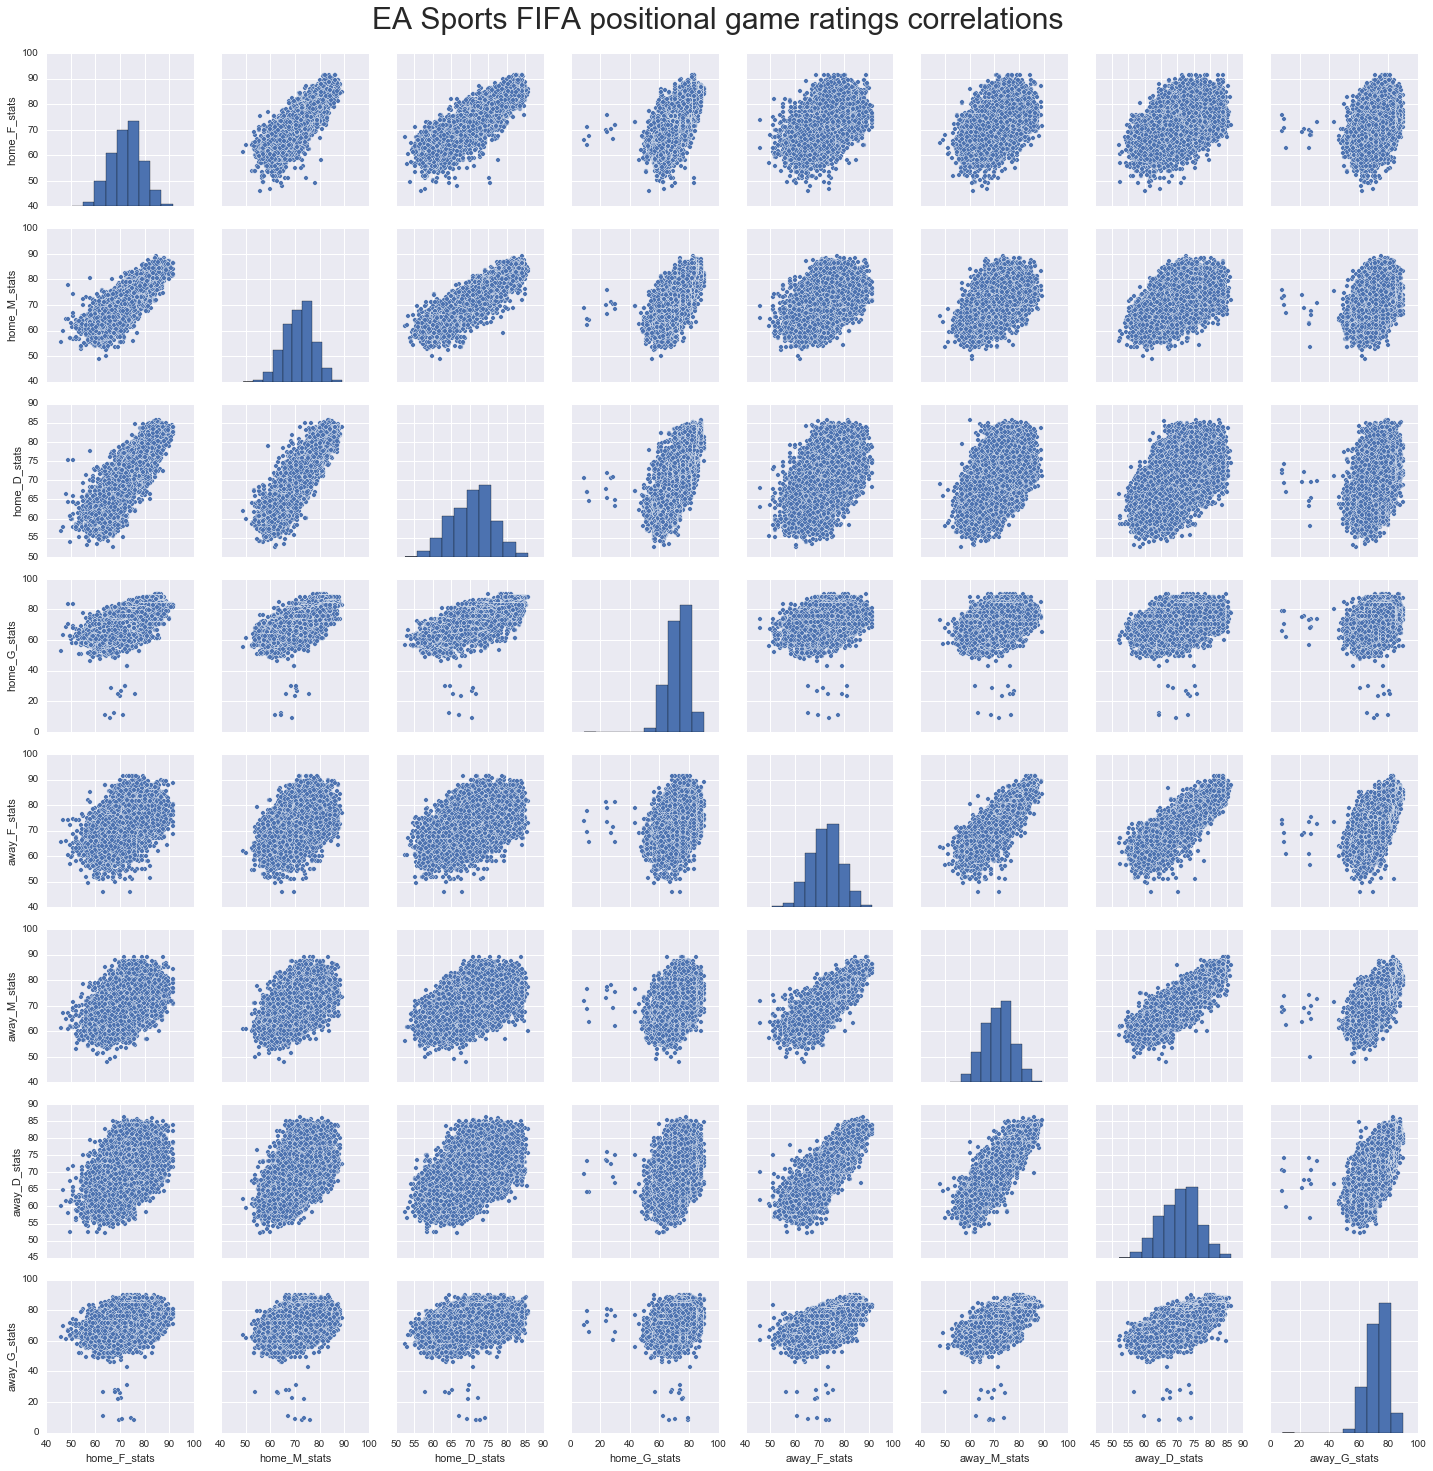

In [35]:
sns.pairplot(data=df[features_1])
plt.suptitle('EA Sports FIFA positional game ratings correlations', fontsize=30, y=1.02)
plt.savefig('ea_fifa_8_feature_comparison.png', bbox_inches='tight', dpi=144)

The top left quadrant shows how home scores are largely correlated with eachother, the same is true for away teams as seen in the bottom right quadrant. The other two quadrants are also redundant, looking at these we see a nicely distributed dataset. Looking at the histrograms we see that our features are normally distributed meaning we have a good amount of data from which to draw accurate conclusions.

I want to know the density of games as a function of time.

bin_width = 28.5 days


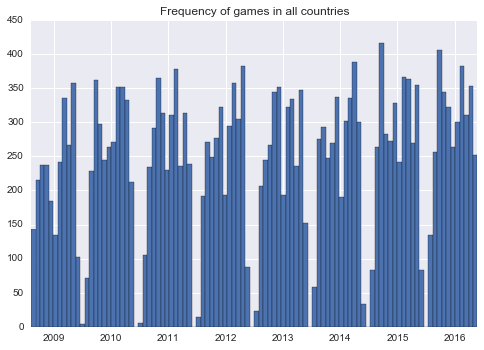

In [36]:
fig, ax = plt.subplots()
ax = df.date.hist(bins=100)
plt.title('Frequency of games in all countries')

#print('Bin width =', bin_width)

plot_width = (df.date.max() - df.date.min()).days
bin_width = plot_width/100
print('bin_width = {0:.1f} days'.format(bin_width))

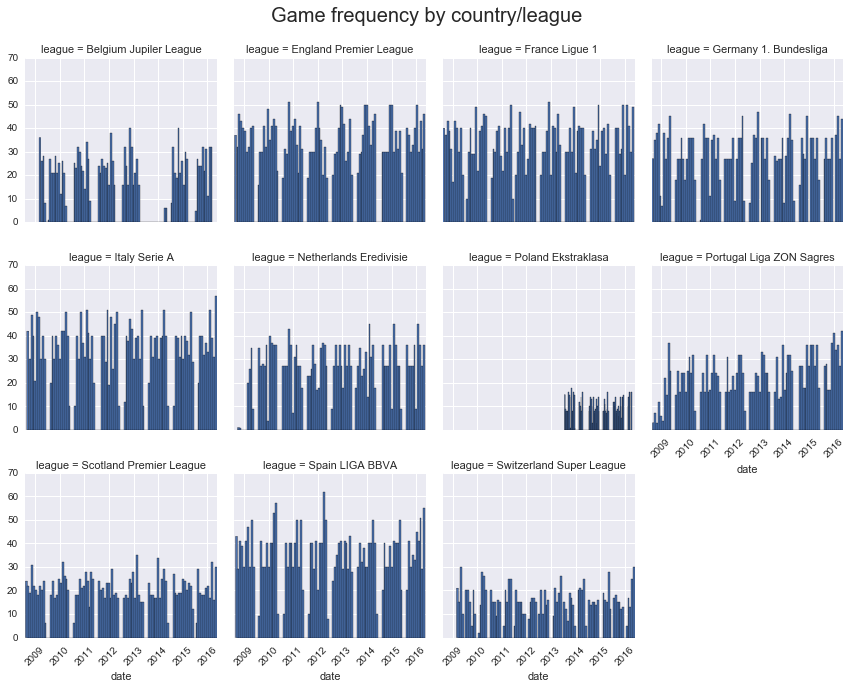

In [37]:
g = sns.FacetGrid(df, col='league', col_wrap=4)
g.map(plt.hist, 'date', bins=100)

for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.suptitle('Game frequency by country/league', fontsize=20, y=1.04)
plt.savefig('game_frequency.png', bbox_inches='tight', dpi=144)

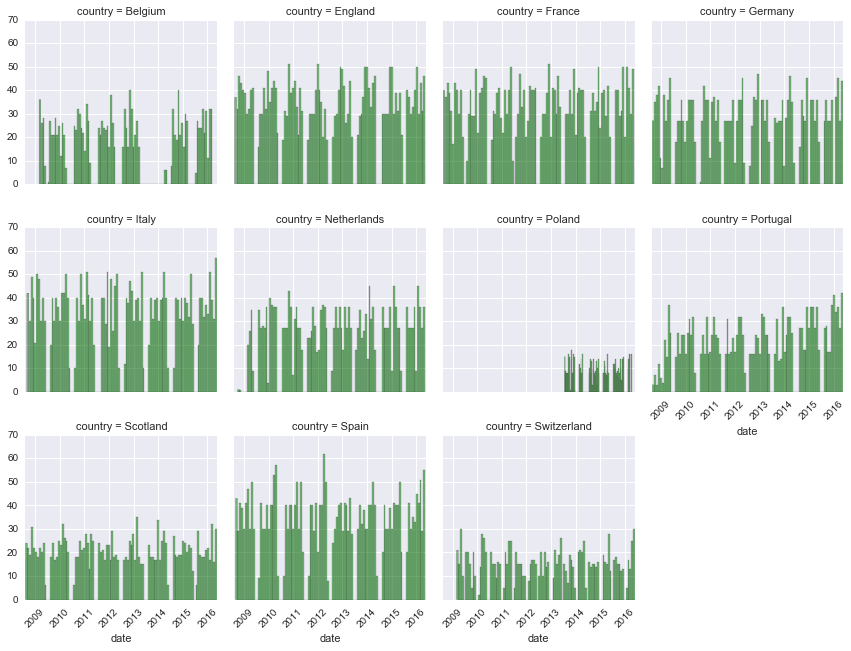

In [38]:
# There is only one league per country so we get
# the same plot from doing this:
g = sns.FacetGrid(df, col='country', col_wrap=4)
g.map(plt.hist, 'date', bins=100, color='green', alpha=0.5)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

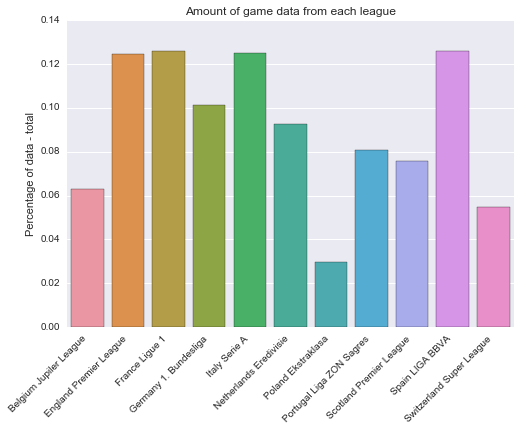

In [39]:
league = np.unique(df.league.values)
N_entries = np.array([len(df[(df.league == L)]) for L in league])
N_entries = N_entries/N_entries.sum()
ax = sns.barplot(league, N_entries)
ax.set_ylabel('Percentage of data - total')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Amount of game data from each league')
plt.show();

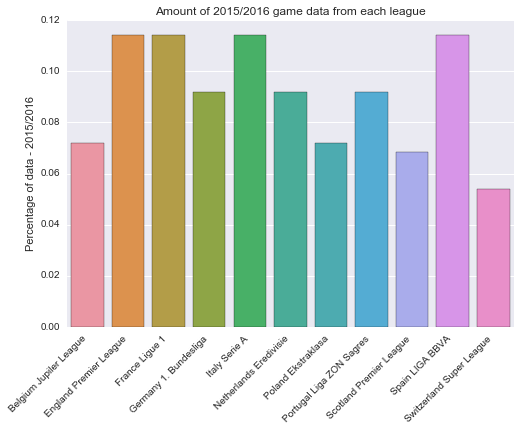

In [40]:
league = np.unique(df.league.values)
N_entries = np.array([len(df[(df.league == L)&(df.season == '2015/2016')]) for L in league])
N_entries = N_entries/N_entries.sum()
ax = sns.barplot(league, N_entries)
ax.set_ylabel('Percentage of data - 2015/2016')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Amount of 2015/2016 game data from each league')

plt.show();

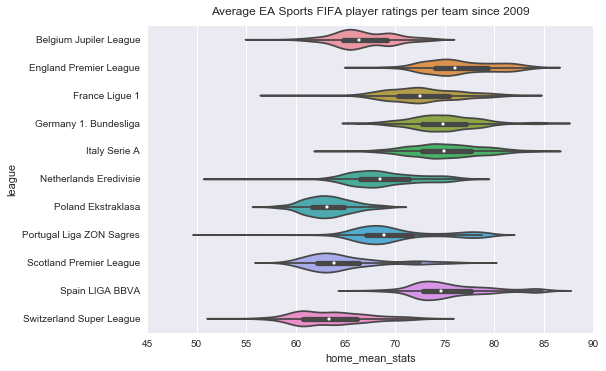

In [41]:
sns.violinplot(x='home_mean_stats', y='league', data=df)
plt.title('Average EA Sports FIFA player ratings per team since 2009', y=1.02)
plt.savefig('mean_ratings_violin.png', bbox_inches='tight', dpi=144)

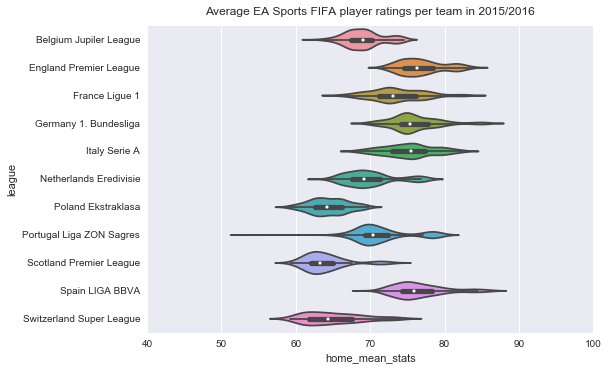

In [42]:
sns.violinplot(x='home_mean_stats', y='league', data=df[(df.season=='2015/2016')])
plt.title('Average EA Sports FIFA player ratings per team in 2015/2016', y=1.02)
plt.savefig('mean_ratings_2016_violin.png', bbox_inches='tight', dpi=144)

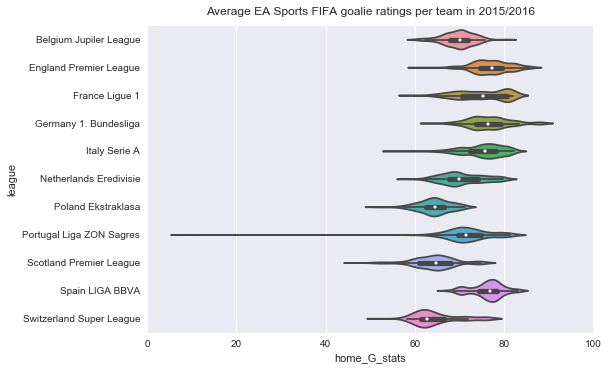

In [43]:
sns.violinplot(x='home_G_stats', y='league', data=df[(df.season=='2015/2016')])
plt.title('Average EA Sports FIFA goalie ratings per team in 2015/2016', y=1.02)
plt.savefig('mean_ratings_2016_violin.png', bbox_inches='tight', dpi=144)

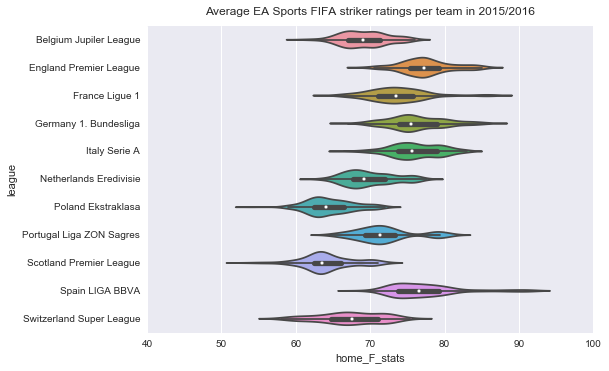

In [44]:
sns.violinplot(x='home_F_stats', y='league', data=df[(df.season=='2015/2016')])
plt.title('Average EA Sports FIFA striker ratings per team in 2015/2016', y=1.02)
plt.savefig('mean_ratings_2016_violin.png', bbox_inches='tight', dpi=144)

## Classification with logistic regression and random forests in `scikit-learn`
- Logistic regression one vs all?
    - Not good with mixed data (if some is discrete (categorical) and some continuous)
- Decision trees?
    - Andrew insists I use boosted trees (XGBoost), maybe I'll try after

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

In [51]:
list(df.columns)

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_F_stats',
 'home_M_stats',
 'home_D_stats',
 'home_G_stats',
 'away_F_stats',
 'away_M_stats',
 'away_D_stats',
 'away_G_stats',
 'game_state',
 'game_result',
 'country',
 'league',
 'home_mean_stats',
 'away_mean_stats']

In [50]:
features_1

['home_F_stats',
 'home_M_stats',
 'home_D_stats',
 'home_G_stats',
 'away_F_stats',
 'away_M_stats',
 'away_D_stats',
 'away_G_stats']

In [65]:
X_train = df[features_1].values
y_train = df.game_result.values

stdScaler = StandardScaler()
X_train_std = stdScaler.fit_transform(X_train)

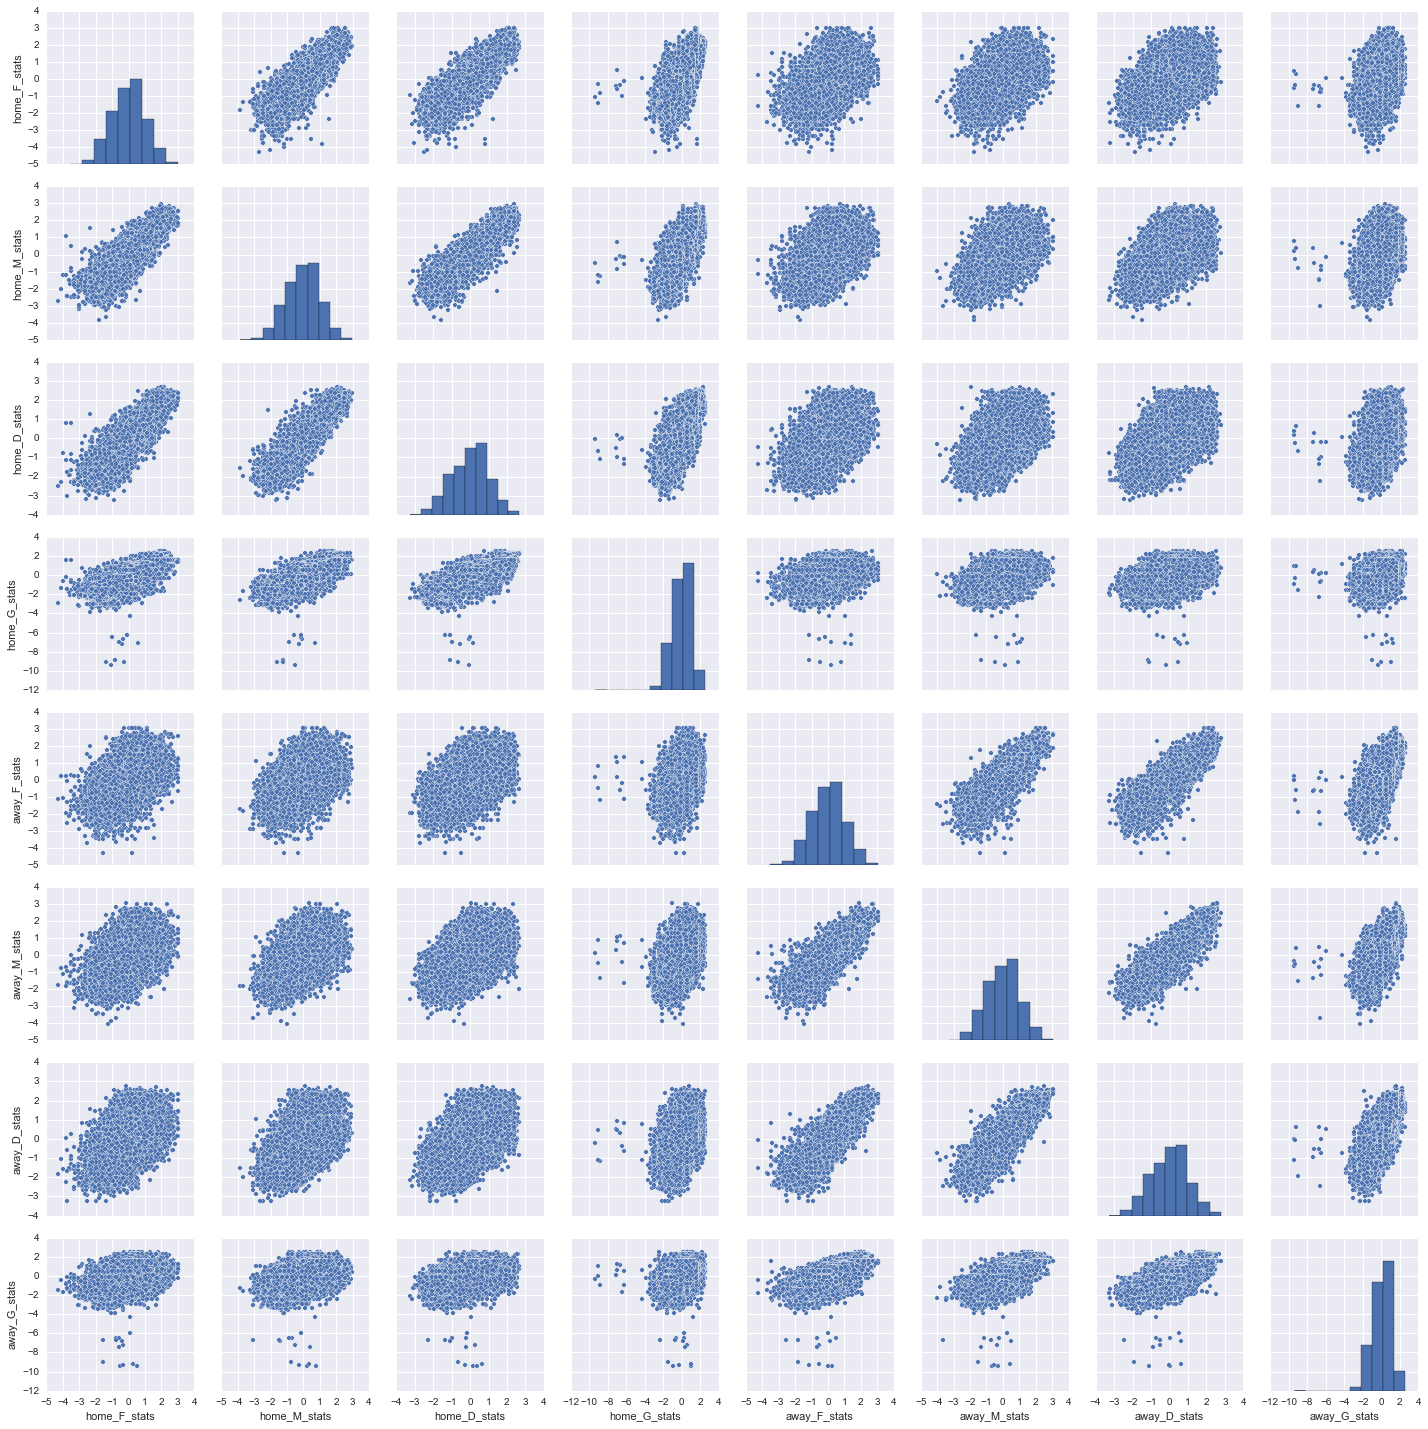

In [71]:
sns.pairplot(pd.DataFrame(X_train_std, columns=features_1))

What if we __do not__ use the scaled values?

In [91]:
lr = LogisticRegression(penalty='l2', C=10**(-1), random_state=0)
scores = cross_val_score(estimator=lr, X=X_train, y=y_train,
                         cv=5, n_jobs=1)
print('For regularization parameter c = -1, mean score = {} +/- {}'.format(np.mean(scores), np.std(scores)))

For regularization parameter c = -1, mean score = 0.525898835349526 +/- 0.0071599160518853


We'll use the standard scaled data from here out, but it doesn't seem to make much difference for logistic regression.

In [103]:
c_scores, c_vals = [], []
for c in range(-4,4):
    lr = LogisticRegression(penalty='l2', C=10**c, random_state=0)
    scores = cross_val_score(estimator=lr, X=X_train_std, y=y_train,
                             cv=5, n_jobs=1)
#    print('K-Fold cross validation scores =', scores)
    print('For c = {}, Mean score = {} +/- {}'.format(c, np.mean(scores), np.std(scores)))
    c_scores.append(np.mean(scores))
    c_vals.append(c)

For c = -4, Mean score = 0.5174798921413455 +/- 0.0084499162437679
For c = -3, Mean score = 0.5237007407176133 +/- 0.006442519279244
For c = -2, Mean score = 0.5259402861338633 +/- 0.007511464415117901
For c = -1, Mean score = 0.5260231360755434 +/- 0.007473740587479902
For c = 0, Mean score = 0.5258987493734775 +/- 0.00739123778585061
For c = 1, Mean score = 0.5258987493734775 +/- 0.00739123778585061
For c = 2, Mean score = 0.5258987493734775 +/- 0.00739123778585061
For c = 3, Mean score = 0.5258987493734775 +/- 0.00739123778585061


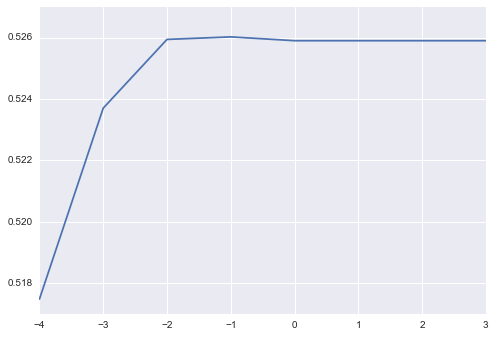

In [93]:
plt.plot(c_vals, c_scores)

Lets train a model and check some game probabilities. Even though we can only predict the correct outcome 52% of the time we should keep in mind that we have 3 possible results for each match giving a random guess benchmark of 33%.

In [109]:
clf = LogisticRegression(penalty='l2', C=10**(-1), random_state=0)
clf.fit(X_train_std, y_train);

What are the `[home-team-win, draw, away-team-win]` probabilities for some random games.

In [98]:
print(clf.predict_proba(X_train_std[0].reshape(1, -1)))
print(clf.predict_proba(X_train_std[1200].reshape(1, -1)))
print(clf.predict_proba(X_train_std[9900].reshape(1, -1)))

[[ 0.17239852  0.28983765  0.53776383]]
[[ 0.67073952  0.2329527   0.09630778]]
[[ 0.20274617  0.27686882  0.52038501]]


Scikit-learn automatically trained three classifiers using the one-vs-all method and each has 8 parameters.

In [115]:
clf.coef_.shape

(3, 8)

We'll look at the coefficients of the first trained model, which classifies between wins and _not_ wins. i.e. wins vs draws and losses

In [116]:
np.set_printoptions(2)
print(clf.coef_[0])

[ 0.27  0.33  0.33  0.02 -0.22 -0.23 -0.38 -0.07]


Does a random forest perform better?

In [261]:
N = 1000
clf = RandomForestClassifier(criterion='gini', n_estimators=N, random_state=0)
scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=5, n_jobs=1)
print(N, 'estimators trained per fold')
print('Mean k-fold score = {} +/- {}'.format(np.mean(scores), np.std(scores)))

1000 estimators trained per fold
Mean k-fold score = 0.5042914530500519 +/- 0.009767249236173305


In [240]:
N = 1000
max_depth = np.arange(2,15,2)

feature_names = df[features_1].columns

scores, feature_importances = [], []
for di, d in enumerate(max_depth):
    
    clf = RandomForestClassifier(n_estimators=N, max_depth=d, random_state=0)
    scores.append(cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=5, n_jobs=1))
    print('Depth = {}'.format(d),\
          'Mean k-fold score = {} +/- {}'.format(np.mean(scores[di]), np.std(scores[di])))
    
    clf.fit(X_train_std, y_train)
    feature_importances.append(clf.feature_importances_)

Depth = 2 Mean k-fold score = 0.4928871086386521 +/- 0.00755574157074534
Depth = 4 Mean k-fold score = 0.5128769131922255 +/- 0.0035198929602016167
Depth = 6 Mean k-fold score = 0.5220007604557023 +/- 0.00772797645828656
Depth = 8 Mean k-fold score = 0.5241154719047103 +/- 0.0076293875675728425
Depth = 10 Mean k-fold score = 0.5240324155869945 +/- 0.007465179607526032
Depth = 12 Mean k-fold score = 0.5207560764058304 +/- 0.008208243237632685
Depth = 14 Mean k-fold score = 0.5177286740168118 +/- 0.007994423865074969


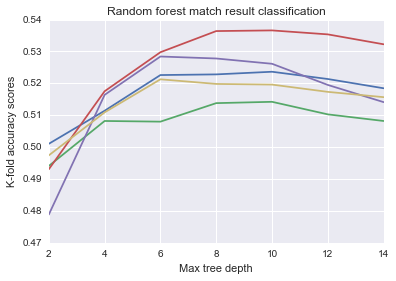

In [241]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(scores)
ax.set_xticks(np.arange(len(scores)))
ax.set_xticklabels(max_depth)
ax.set_title('Random forest match result classification')
ax.set_xlabel('Max tree depth')
ax.set_ylabel('K-fold accuracy scores')
plt.savefig('feature_subset_1_forest_kfold.png', bbox_inches='tight', dpi=144)

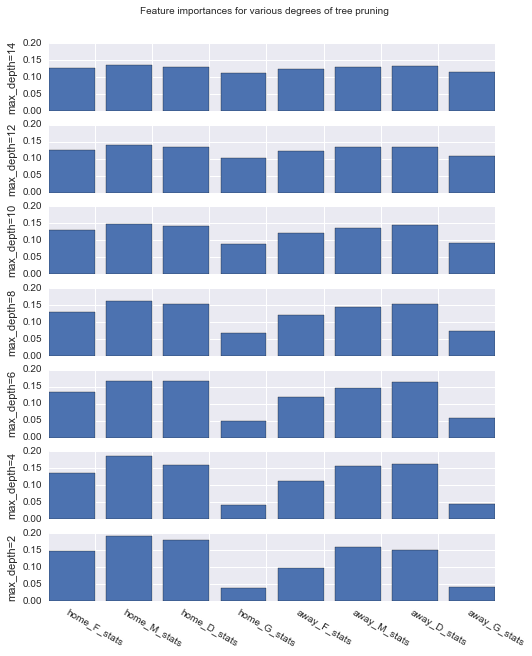

In [242]:
fig, ax = plt.subplots(len(max_depth), 1,
                       sharex=True, sharey=True,
                       figsize=(8, 10))

for di, d in enumerate(max_depth):

    i = len(max_depth)-di-1
    ax[i].bar(np.arange(len(feature_importances[di])),
              feature_importances[di])
    ax[i].set_xticks(np.arange(len(feature_importances[di]))+0.8)
    ax[i].set_xticklabels(features_1)
    ax[i].set_ylabel('max_depth={}'.format(d))
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=-30)
    
plt.suptitle('Feature importances for various degrees of tree pruning', y=0.95)
plt.savefig('feature_subset_1_importances.png', bbox_inches='tight', dpi=144)

Let's print the decision tree for a model fit on the entire data set. With `max_depth = 6` we already have a very complicated tree. 

In [262]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=6, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_3.dot',
                feature_names=df[features_1].columns)

You'll need to have graphviz installed to convert the `.dot` files to `.png`, the relevant command line execution looks like this:
```
dot -Tpng tree.dot -o tree.png
```

In [243]:
from IPython.core.display import Image

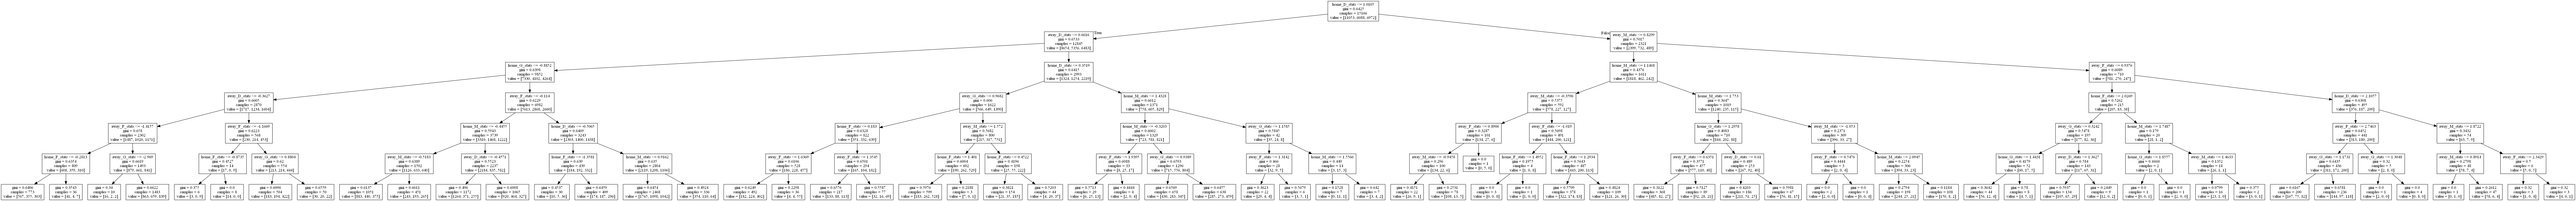

In [248]:
Image('tree_feature_subset_1_max_depth_6.png')

It may be difficult to see anything in the ipython notebook, but the files are high resolution.

Let's so the same for `max_depth = 3` and then `max_depth = 2`.

In [263]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_3.dot',
                feature_names=df[features_1].columns)

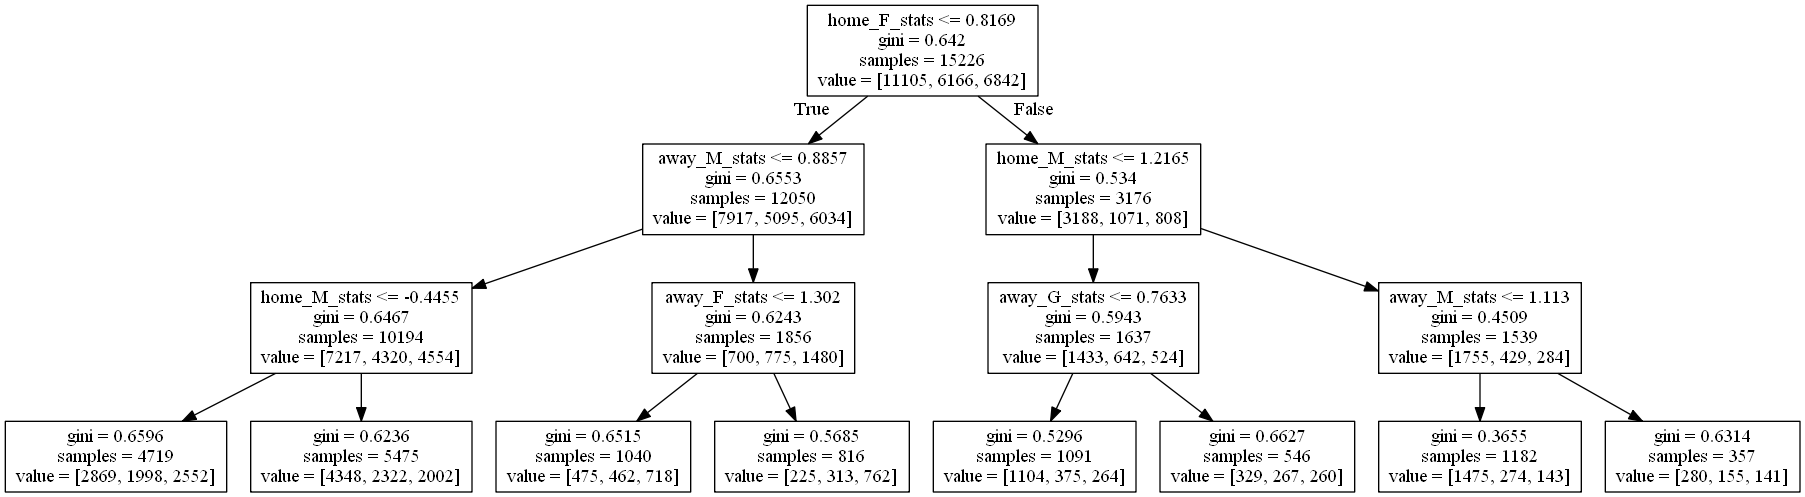

In [254]:
Image('tree_feature_subset_1_max_depth_3.png')

In [264]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_2.dot',
                feature_names=df[features_1].columns)

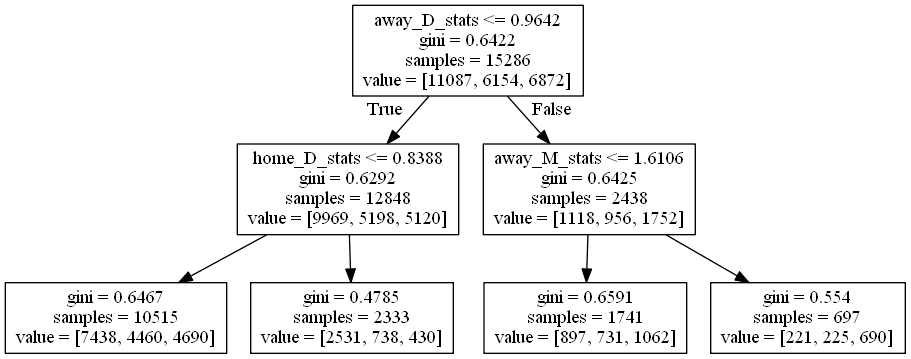

In [256]:
Image('tree_feature_subset_1_max_depth_2.png')

The decision tree splits on the feature that yields the highest information gain (a maximization problem). The `gini` value in each cell is the _information gain_ of the decided feature from which to split on. As well as the gini index, we have access to the _entropy_ information gain.

In [265]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, criterion='entropy', random_state=0)
clf.fit(X_train_std, y_train)
export_graphviz(clf.estimators_[0], out_file='tree_feature_subset_1_max_depth_2_entropy.dot',
                feature_names=df[features_1].columns)

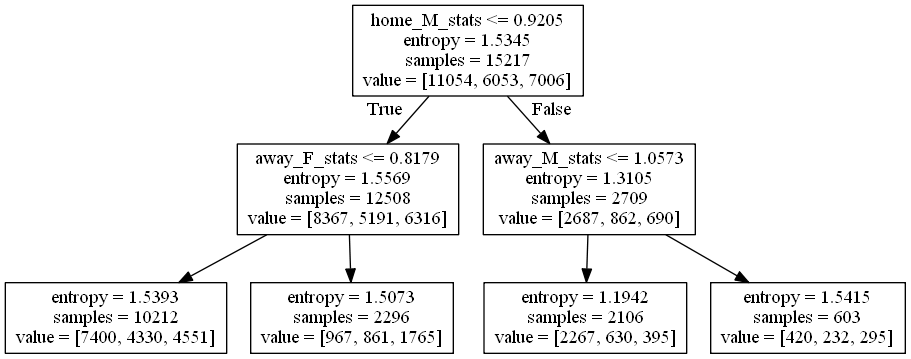

In [266]:
Image('tree_feature_subset_1_max_depth_2_entropy.png')

The `value` list in each cell holds the number of samples that land in that bin. These generate the probabilities of our selection. For example the bottom right list has 420 home team wins, 232 draws, and 295 home team losses. The prediction for samples landing in the cell would be that the home team wins. 

In [282]:
np.set_printoptions(2)
print(clf.predict_proba(X_train_std[0].reshape(1,-1)))
print(clf.predict_proba(X_train_std[4095].reshape(1,-1)))
print(clf.predict_proba(X_train_std[5990].reshape(1,-1)))
print(clf.predict_proba(X_train_std[5830].reshape(1,-1)))

[[ 0.44  0.27  0.29]]
[[ 0.29  0.25  0.46]]
[[ 0.67  0.2   0.13]]
[[ 0.34  0.26  0.4 ]]


These four class prediction probabilities correspond to the four final cells in the tree. As seen below, we can calculate probabilities based on the `value` list showing class populations.

In [283]:
value = [[7400, 4330, 4551], [967, 861, 1765], [2267, 630, 395], [420, 232, 295]]
np.array([[v/sum(val) for v in val] for val in value])

array([[ 0.45,  0.27,  0.28],
       [ 0.27,  0.24,  0.49],
       [ 0.69,  0.19,  0.12],
       [ 0.44,  0.24,  0.31]])